In [717]:
import numpy as np
import os
import shutil
import pandas as pd
import sys
import gzip
import nibabel as nib
from matplotlib import pyplot as plt
from scipy import stats
import copy
import re

## Import Files

In [718]:
path = '/Users/nanatang/VAserversim/m/Researchers/SerenaT/fromjapan_fullruns/'

In [719]:
reportfile = 'grand_PVS_report.csv'
report = pd.read_csv(os.path.join(path,reportfile))

reportrawfile = 'grand_PVS_report_RAW.csv'
reportraw = pd.read_csv(os.path.join(path,reportrawfile))

demofile = 'idaSearch_2_21_2024-ADNI3.csv'
demo = pd.read_csv(os.path.join(path,demofile))

imagelistfile = 'imagelist_adni3frangi_T1only.csv'
imagelist = pd.read_csv(os.path.join(path,imagelistfile))

imagelistfsdnfile = 'imagelist_adni3fsdn_T1only.csv'
imagelistfsdn = pd.read_csv(os.path.join(path,imagelistfsdnfile))

dxfile = 'dx_adni3.csv'
dx = pd.read_csv(os.path.join(path,dxfile))

faultysubjectfile = 'faulty_subjects.csv'
faultysubjects = pd.read_csv(os.path.join(path,faultysubjectfile),names=['subjects'])

## Missing subjects investigation
- why doesn't the fsdn image list match the frangi image list and which ones don't match
- which subjects that exist in the adni3_frangi list are missing years in the grand report
- any other discrepancies

Step 1: harmonize by making all the files have the same columns (at least: subject codes (just the number), Scan code (subject codes and the year),
        visit code, and image code)

In [720]:
dx_clean = pd.DataFrame({'SubjectCodes':dx['PTID'],'Diagnosis':dx['DIAGNOSIS']})
dx_clean = dx_clean.groupby('SubjectCodes').agg({'Diagnosis':'first'})
dx_clean.reset_index(inplace=True)
dx_clean.drop_duplicates('SubjectCodes',inplace=True)
dx_clean.dropna(inplace=True)
dx_clean['Diagnosis'] = dx_clean['Diagnosis'].apply(str)
replacements = {'1.0':'CN','2.0': 'MCI', '3.0': 'AD'}
dx_clean['Diagnosis'] = dx_clean['Diagnosis'].map(replacements).fillna(dx_clean['Diagnosis'])

dx_clean

,SubjectCodes,Diagnosis
0,002_S_0413,CN
1,002_S_1155,MCI
2,002_S_1261,MCI
3,002_S_1280,CN
4,002_S_4213,CN
...,...,...
1354,941_S_7074,CN
1355,941_S_7085,MCI
1356,941_S_7087,CN
1357,941_S_7091,CN


In [721]:
subjcodes = []
for subj in imagelist['Code'].array:
    pattern = re.compile('\d{3}_\w_\d{4}')
    subjcodes.append(re.search(pattern,subj)[0])
imagecodes = []
for image in imagelist['Code'].array:
    pattern = re.compile('i\d*')
    imagecodes.append(re.search(pattern,image)[0])
visitcodes = []
for visit in imagelist['Code'].array:
    pattern = re.compile('y\d{2}')
    visitcodes.append(re.search(pattern,visit)[0])
imagelist.insert(1,'SubjectCodes',subjcodes)
imagelist.insert(2,'ImageCodes',imagecodes)
imagelist.insert(3,'VisitCodes',visitcodes)


In [722]:
subjcodes = []
for subj in imagelistfsdn['Code'].array:
    pattern = re.compile('\d{3}_\w_\d{4}')
    subjcodes.append(re.search(pattern,subj)[0])
imagecodes = []
for image in imagelistfsdn['Code'].array:
    pattern = re.compile('i\d*')
    imagecodes.append(re.search(pattern,image)[0])
visitcodes = []
for visit in imagelistfsdn['Code'].array:
    pattern = re.compile('y\d{2}')
    visitcodes.append(re.search(pattern,visit)[0])
imagelistfsdn.insert(1,'SubjectCodes',subjcodes)
imagelistfsdn.insert(2,'ImageCodes',imagecodes)
imagelistfsdn.insert(3,'VisitCodes',visitcodes)
##imagelistfsdn

In [723]:
subjcodes = []
for subj in reportraw['subjects'].array:
    pattern = re.compile('\d{3}_\w_\d{4}')
    subjcodes.append(re.search(pattern,subj)[0])
imagecodes = []
for image in reportraw['subjects'].array:
    pattern = re.compile('i\d*')
    imagecodes.append(re.search(pattern,image)[0])
visitcodes = []
for visit in reportraw['subjects'].array:
    pattern = re.compile('y\d{2}')
    visitcodes.append(re.search(pattern,visit)[0])
reportraw.insert(2,'SubjectCodes',subjcodes)
reportraw.insert(3,'ImageCodes',imagecodes)
reportraw.insert(4,'VisitCodes',visitcodes)

scancodes = 'ADNI3_' + reportraw['SubjectCodes'] + reportraw['VisitCodes']
reportraw.insert(2,'ScanCode',scancodes)
#reportraw

In [724]:
subjcodes = []
for subj in report['subjects'].array:
    pattern = re.compile('\d{3}_\w_\d{4}')
    subjcodes.append(re.search(pattern,subj)[0])
imagecodes = []
for image in report['subjects'].array:
    pattern = re.compile('i\d*')
    imagecodes.append(re.search(pattern,image)[0])
visitcodes = []
for visit in report['subjects'].array:
    pattern = re.compile('y\d{2}')
    visitcodes.append(re.search(pattern,visit)[0])
report.insert(2,'SubjectCodes',subjcodes)
report.insert(3,'ImageCodes',imagecodes)
report.insert(4,'VisitCodes',visitcodes)

scancodes = 'ADNI3_' + report['SubjectCodes'] + report['VisitCodes']
report.insert(2,'ScanCode',scancodes)
#report

Step 2: make a deep copy so you don't screw things up when you merge

In [725]:
imagelistfsdn_copy = copy.deepcopy(imagelistfsdn)
imagelist['check'] = 'yes'
imagelist

,Code,SubjectCodes,ImageCodes,VisitCodes,ScanCode,ImageType,ImageStore,ResearchGroup,check
0,ADNI3_002_S_0413y00_i863056,002_S_0413,i863056,y00,ADNI3_002_S_0413y00,T1,Dicom,CN,yes
1,ADNI3_002_S_0413y02_i1221051,002_S_0413,i1221051,y02,ADNI3_002_S_0413y02,T1,Dicom,CN,yes
2,ADNI3_002_S_1155y00_i843510,002_S_1155,i843510,y00,ADNI3_002_S_1155y00,T1,Dicom,MCI,yes
3,ADNI3_002_S_1155y01_i995496,002_S_1155,i995496,y01,ADNI3_002_S_1155y01,T1,Dicom,MCI,yes
4,ADNI3_002_S_1155y02_i1270004,002_S_1155,i1270004,y02,ADNI3_002_S_1155y02,T1,Dicom,MCI,yes
...,...,...,...,...,...,...,...,...,...
2130,ADNI3_941_S_7051y00_i1553005,941_S_7051,i1553005,y00,ADNI3_941_S_7051y00,T1,Dicom,CN,yes
2131,ADNI3_941_S_7074y00_i1588331,941_S_7074,i1588331,y00,ADNI3_941_S_7074y00,T1,Dicom,CN,yes
2132,ADNI3_941_S_7085y00_i1600180,941_S_7085,i1600180,y00,ADNI3_941_S_7085y00,T1,Dicom,MCI,yes
2133,ADNI3_941_S_7087y00_i1591321,941_S_7087,i1591321,y00,ADNI3_941_S_7087y00,T1,Dicom,CN,yes


In [726]:
imagelistcopy = copy.deepcopy(imagelist)
reportcopy = copy.deepcopy(report)
reportcopy.drop_duplicates('subjects',inplace=True)    
imagelistcopy                 

,Code,SubjectCodes,ImageCodes,VisitCodes,ScanCode,ImageType,ImageStore,ResearchGroup,check
0,ADNI3_002_S_0413y00_i863056,002_S_0413,i863056,y00,ADNI3_002_S_0413y00,T1,Dicom,CN,yes
1,ADNI3_002_S_0413y02_i1221051,002_S_0413,i1221051,y02,ADNI3_002_S_0413y02,T1,Dicom,CN,yes
2,ADNI3_002_S_1155y00_i843510,002_S_1155,i843510,y00,ADNI3_002_S_1155y00,T1,Dicom,MCI,yes
3,ADNI3_002_S_1155y01_i995496,002_S_1155,i995496,y01,ADNI3_002_S_1155y01,T1,Dicom,MCI,yes
4,ADNI3_002_S_1155y02_i1270004,002_S_1155,i1270004,y02,ADNI3_002_S_1155y02,T1,Dicom,MCI,yes
...,...,...,...,...,...,...,...,...,...
2130,ADNI3_941_S_7051y00_i1553005,941_S_7051,i1553005,y00,ADNI3_941_S_7051y00,T1,Dicom,CN,yes
2131,ADNI3_941_S_7074y00_i1588331,941_S_7074,i1588331,y00,ADNI3_941_S_7074y00,T1,Dicom,CN,yes
2132,ADNI3_941_S_7085y00_i1600180,941_S_7085,i1600180,y00,ADNI3_941_S_7085y00,T1,Dicom,MCI,yes
2133,ADNI3_941_S_7087y00_i1591321,941_S_7087,i1591321,y00,ADNI3_941_S_7087y00,T1,Dicom,CN,yes


In [727]:
reportrawcopy = copy.deepcopy(reportraw)
reportrawcopy.drop_duplicates('subjects',inplace=True)    
reportrawcopy

,subjects,research group,ScanCode,SubjectCodes,ImageCodes,VisitCodes,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask
0,ADNI3_114_S_2392y00_i909791,EMCI,ADNI3_114_S_2392y00,114_S_2392,i909791,y00,7767.0,16143.0,0.010479,6340.0,12022.0,0.007804,yes,yes
1,ADNI3_114_S_4404y00_i949873,EMCI,ADNI3_114_S_4404y00,114_S_4404,i949873,y00,5305.0,12342.0,0.009983,4129.0,8364.0,0.006765,yes,yes
2,ADNI3_128_S_4742y00_i1039209,EMCI,ADNI3_128_S_4742y00,128_S_4742,i1039209,y00,4057.0,15064.0,0.009716,2872.0,9966.0,0.006428,yes,yes
3,ADNI3_027_S_4919y04_i1398602,EMCI,ADNI3_027_S_4919y04,027_S_4919,i1398602,y04,3457.0,11502.0,0.008411,2782.0,7978.0,0.005834,yes,yes
4,ADNI3_067_S_2304y02_i1215232,EMCI,ADNI3_067_S_2304y02,067_S_2304,i1215232,y02,4856.0,13188.0,0.007504,3861.0,9106.0,0.005181,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,ADNI3_941_S_7074y00_i1588331,CN,ADNI3_941_S_7074y00,941_S_7074,i1588331,y00,4343.0,10179.0,0.007051,3410.0,6967.0,0.004826,yes,yes
2021,ADNI3_941_S_7085y00_i1600180,MCI,ADNI3_941_S_7085y00,941_S_7085,i1600180,y00,4362.0,9364.0,0.006991,3452.0,5785.0,0.004319,yes,yes
2022,ADNI3_941_S_7051y00_i1553005,CN,ADNI3_941_S_7051y00,941_S_7051,i1553005,y00,4365.0,14324.0,0.009672,3430.0,10342.0,0.006983,yes,yes
2023,ADNI3_941_S_7106y00_i1619403,MCI,ADNI3_941_S_7106y00,941_S_7106,i1619403,y00,3619.0,8365.0,0.005978,2479.0,4798.0,0.003429,yes,yes


Step 3: do your merging and investigating

Check which subjects are missing from the ADNI3_frangi list based on ADNI3_FSdn list

In [728]:
mergedimagelist = imagelistfsdn_copy.merge(imagelist,how='left',on='ImageCodes')

In [729]:
## this tells you which subjects are missing from ADNI3_frangi that don't match ADNI3_FSdn
## specifically, the last 3 don't match
nullmask = mergedimagelist.isnull().any(axis=1)
nullrow = mergedimagelist[nullmask]
nullrow

,Code_x,SubjectCodes_x,ImageCodes,VisitCodes_x,ScanCode_x,ImageType_x,ImageStore_x,Code_y,SubjectCodes_y,VisitCodes_y,ScanCode_y,ImageType_y,ImageStore_y,ResearchGroup,check
573,ADNI3_024_S_7025y00_i1515286,024_S_7025,i1515286,y00,ADNI3_024_S_7025y00,T1,Dicom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
978,ADNI3_051_S_6527y00_i1043951,051_S_6527,i1043951,y00,ADNI3_051_S_6527y00,T1,Dicom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1580,ADNI3_129_S_6482y00_i1021033,129_S_6482,i1021033,y00,ADNI3_129_S_6482y00,T1,Dicom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993,ADNI3_305_S_6263y00_i971096,305_S_6263,i971096,y00,ADNI3_305_S_6263y00,T1,Dicom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [730]:
nullrow.to_csv(os.path.join(path,'missingsubjects_fromimagelist.csv'))

Check which subjects are missing from the grand PVS report based on ADNI3_frangi list
- this will give you everything including those missing T1, WMH, and visit

In [731]:
imagelistreport_merge = imagelistcopy.merge(reportcopy,how='left',on='ScanCode')
imagelistreport_merge.drop_duplicates('Code',inplace=True)
imagelistreport_merge

,Code,SubjectCodes_x,ImageCodes_x,VisitCodes_x,ScanCode,ImageType,ImageStore,ResearchGroup,check,subjects,...,ImageCodes_y,VisitCodes_y,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask
0,ADNI3_002_S_0413y00_i863056,002_S_0413,i863056,y00,ADNI3_002_S_0413y00,T1,Dicom,CN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADNI3_002_S_0413y02_i1221051,002_S_0413,i1221051,y02,ADNI3_002_S_0413y02,T1,Dicom,CN,yes,ADNI3_002_S_0413y02_i1221051,...,i1221051,y02,1945.0,8300.0,0.005403,1302.0,4470.0,0.002910,no,yes
2,ADNI3_002_S_1155y00_i843510,002_S_1155,i843510,y00,ADNI3_002_S_1155y00,T1,Dicom,MCI,yes,ADNI3_002_S_1155y00_i843510,...,i843510,y00,738.0,3356.0,0.002123,210.0,660.0,0.000418,no,yes
3,ADNI3_002_S_1155y01_i995496,002_S_1155,i995496,y01,ADNI3_002_S_1155y01,T1,Dicom,MCI,yes,ADNI3_002_S_1155y01_i995496,...,i995496,y01,1988.0,7332.0,0.004549,1069.0,2793.0,0.001733,no,yes
4,ADNI3_002_S_1155y02_i1270004,002_S_1155,i1270004,y02,ADNI3_002_S_1155y02,T1,Dicom,MCI,yes,ADNI3_002_S_1155y02_i1270004,...,i1270004,y02,2020.0,8060.0,0.004978,1087.0,2856.0,0.001764,no,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,ADNI3_941_S_7051y00_i1553005,941_S_7051,i1553005,y00,ADNI3_941_S_7051y00,T1,Dicom,CN,yes,ADNI3_941_S_7051y00_i1553005,...,i1553005,y00,2010.0,10314.0,0.006964,1403.0,6060.0,0.004092,no,yes
2139,ADNI3_941_S_7074y00_i1588331,941_S_7074,i1588331,y00,ADNI3_941_S_7074y00,T1,Dicom,CN,yes,ADNI3_941_S_7074y00_i1588331,...,i1588331,y00,1509.0,6289.0,0.004356,969.0,2831.0,0.001961,no,yes
2140,ADNI3_941_S_7085y00_i1600180,941_S_7085,i1600180,y00,ADNI3_941_S_7085y00,T1,Dicom,MCI,yes,ADNI3_941_S_7085y00_i1600180,...,i1600180,y00,1607.0,4441.0,0.003315,954.0,1890.0,0.001411,no,yes
2141,ADNI3_941_S_7087y00_i1591321,941_S_7087,i1591321,y00,ADNI3_941_S_7087y00,T1,Dicom,CN,yes,ADNI3_941_S_7087y00_i1591321,...,i1591321,y00,1989.0,7926.0,0.004448,997.0,2721.0,0.001527,no,yes


In [732]:
## this tells you which ones are missing, whether due to T1 missing, or WMH missing, or missing visit code, or some other reason
nullmask = imagelistreport_merge.isnull().any(axis=1)
nullrow = imagelistreport_merge[nullmask]
nullrow

,Code,SubjectCodes_x,ImageCodes_x,VisitCodes_x,ScanCode,ImageType,ImageStore,ResearchGroup,check,subjects,...,ImageCodes_y,VisitCodes_y,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask
0,ADNI3_002_S_0413y00_i863056,002_S_0413,i863056,y00,ADNI3_002_S_0413y00,T1,Dicom,CN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,ADNI3_002_S_5230y02_i1270084,002_S_5230,i1270084,y02,ADNI3_002_S_5230y02,T1,Dicom,SMC,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,ADNI3_003_S_4288y04_i1498579,003_S_4288,i1498579,y04,ADNI3_003_S_4288y04,T1,Dicom,CN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,ADNI3_003_S_6959y00_i1456305,003_S_6959,i1456305,y00,ADNI3_003_S_6959y00,T1,Dicom,CN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,ADNI3_003_S_7010y00_i1495816,003_S_7010,i1495816,y00,ADNI3_003_S_7010y00,T1,Dicom,CN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114,ADNI3_941_S_6546y04_i1624954,941_S_6546,i1624954,y04,ADNI3_941_S_6546y04,T1,Dicom,CN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2126,ADNI3_941_S_6580y04_i1624283,941_S_6580,i1624283,y04,ADNI3_941_S_6580y04,T1,Dicom,CN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,ADNI3_941_S_6581y02_i1343754,941_S_6581,i1343754,y02,ADNI3_941_S_6581y02,T1,Dicom,CN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2131,ADNI3_941_S_6854y01_i1428390,941_S_6854,i1428390,y01,ADNI3_941_S_6854y01,T1,Dicom,AD,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [733]:
nullrow.to_csv(os.path.join(path,'missingsubjectsfile.csv'))

Same thing but for raw grand report

In [734]:
imagelistreport_merge = imagelistcopy.merge(reportrawcopy,how='left',on='ScanCode')
imagelistreport_merge.drop_duplicates('Code',inplace=True)
imagelistreport_merge

,Code,SubjectCodes_x,ImageCodes_x,VisitCodes_x,ScanCode,ImageType,ImageStore,ResearchGroup,check,subjects,...,ImageCodes_y,VisitCodes_y,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask
0,ADNI3_002_S_0413y00_i863056,002_S_0413,i863056,y00,ADNI3_002_S_0413y00,T1,Dicom,CN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADNI3_002_S_0413y02_i1221051,002_S_0413,i1221051,y02,ADNI3_002_S_0413y02,T1,Dicom,CN,yes,ADNI3_002_S_0413y02_i1221051,...,i1221051,y02,3439.0,10102.0,0.006576,2512.0,6818.0,0.004438,yes,yes
2,ADNI3_002_S_1155y00_i843510,002_S_1155,i843510,y00,ADNI3_002_S_1155y00,T1,Dicom,MCI,yes,ADNI3_002_S_1155y00_i843510,...,i843510,y00,2383.0,9583.0,0.006062,1757.0,4950.0,0.003132,yes,yes
3,ADNI3_002_S_1155y01_i995496,002_S_1155,i995496,y01,ADNI3_002_S_1155y01,T1,Dicom,MCI,yes,ADNI3_002_S_1155y01_i995496,...,i995496,y01,3435.0,9084.0,0.005636,2409.0,5128.0,0.003182,yes,yes
4,ADNI3_002_S_1155y02_i1270004,002_S_1155,i1270004,y02,ADNI3_002_S_1155y02,T1,Dicom,MCI,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,ADNI3_941_S_7051y00_i1553005,941_S_7051,i1553005,y00,ADNI3_941_S_7051y00,T1,Dicom,CN,yes,ADNI3_941_S_7051y00_i1553005,...,i1553005,y00,4365.0,14324.0,0.009672,3430.0,10342.0,0.006983,yes,yes
2139,ADNI3_941_S_7074y00_i1588331,941_S_7074,i1588331,y00,ADNI3_941_S_7074y00,T1,Dicom,CN,yes,ADNI3_941_S_7074y00_i1588331,...,i1588331,y00,4343.0,10179.0,0.007051,3410.0,6967.0,0.004826,yes,yes
2140,ADNI3_941_S_7085y00_i1600180,941_S_7085,i1600180,y00,ADNI3_941_S_7085y00,T1,Dicom,MCI,yes,ADNI3_941_S_7085y00_i1600180,...,i1600180,y00,4362.0,9364.0,0.006991,3452.0,5785.0,0.004319,yes,yes
2141,ADNI3_941_S_7087y00_i1591321,941_S_7087,i1591321,y00,ADNI3_941_S_7087y00,T1,Dicom,CN,yes,ADNI3_941_S_7087y00_i1591321,...,i1591321,y00,5078.0,12396.0,0.006957,3749.0,7351.0,0.004126,yes,yes


In [735]:
## this tells you which ones are missing, whether due to T1 missing, or WMH missing, or missing visit code, or some other reason
nullmaskraw = imagelistreport_merge.isnull().any(axis=1)
nullrowraw = imagelistreport_merge[nullmaskraw]
nullrowraw

,Code,SubjectCodes_x,ImageCodes_x,VisitCodes_x,ScanCode,ImageType,ImageStore,ResearchGroup,check,subjects,...,ImageCodes_y,VisitCodes_y,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask
0,ADNI3_002_S_0413y00_i863056,002_S_0413,i863056,y00,ADNI3_002_S_0413y00,T1,Dicom,CN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ADNI3_002_S_1155y02_i1270004,002_S_1155,i1270004,y02,ADNI3_002_S_1155y02,T1,Dicom,MCI,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ADNI3_002_S_1261y00_i831065,002_S_1261,i831065,y00,ADNI3_002_S_1261y00,T1,Dicom,CN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ADNI3_002_S_1261y01_i989320,002_S_1261,i989320,y01,ADNI3_002_S_1261y01,T1,Dicom,CN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,ADNI3_002_S_5230y02_i1270084,002_S_5230,i1270084,y02,ADNI3_002_S_5230y02,T1,Dicom,SMC,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114,ADNI3_941_S_6546y04_i1624954,941_S_6546,i1624954,y04,ADNI3_941_S_6546y04,T1,Dicom,CN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2126,ADNI3_941_S_6580y04_i1624283,941_S_6580,i1624283,y04,ADNI3_941_S_6580y04,T1,Dicom,CN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,ADNI3_941_S_6581y02_i1343754,941_S_6581,i1343754,y02,ADNI3_941_S_6581y02,T1,Dicom,CN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2131,ADNI3_941_S_6854y01_i1428390,941_S_6854,i1428390,y01,ADNI3_941_S_6854y01,T1,Dicom,AD,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [736]:
nullrowraw.to_csv(os.path.join(path,'missingsubjectsfileRAW.csv'))

Figure out which of the nulls match the faulty image list

In [737]:
faultysubjects

,subjects
0,ADNI3_141_S_6589y00_i1072748: missing raw flair
1,ADNI3_141_S_6589y00_i1072748: missing raw T1
2,ADNI3_141_S_6416y02_i1511356: missing raw flair
3,ADNI3_141_S_6416y02_i1511356: missing raw T1
4,ADNI3_141_S_6423y00_i1018387: missing raw flair
...,...
394,ADNI3_129_S_6146y02_i1277389: missing FSdn T1
395,ADNI3_131_S_6170y02_i1526394: missing FSdn T1
396,ADNI3_135_S_6411y04_i1591979: missing FSdn T1
397,ADNI3_135_S_6411y05_i10238728: missing FSdn T1


In [738]:
subjcodes = []
for subj in faultysubjects['subjects'].array:
    pattern = re.compile('\d{3}_\w_\d{4}')
    subjcodes.append(re.search(pattern,subj)[0])
imagecodes = []
for image in faultysubjects['subjects'].array:
    pattern = re.compile('i\d*')
    imagecodes.append(re.search(pattern,image)[0])
visitcodes = []
for visit in faultysubjects['subjects'].array:
    pattern = re.compile('y\d{2}')
    visitcodes.append(re.search(pattern,visit)[0])

fullsubjcode = []
for c in faultysubjects['subjects'].array:
    pattern = re.compile('ADNI3_\d{3}_\w_\d{4}y\d{2}_i\d*')
    fullsubjcode.append(re.search(pattern,c)[0])


faultysubjects['SubjectCodes'] = subjcodes
faultysubjects['ImageCodes'] = imagecodes
faultysubjects['VisitCodes'] = visitcodes
faultysubjects['Code'] = fullsubjcode


faultysubjects.drop_duplicates('subjects',inplace=True)
faultysubjects

,subjects,SubjectCodes,ImageCodes,VisitCodes,Code
0,ADNI3_141_S_6589y00_i1072748: missing raw flair,141_S_6589,i1072748,y00,ADNI3_141_S_6589y00_i1072748
1,ADNI3_141_S_6589y00_i1072748: missing raw T1,141_S_6589,i1072748,y00,ADNI3_141_S_6589y00_i1072748
2,ADNI3_141_S_6416y02_i1511356: missing raw flair,141_S_6416,i1511356,y02,ADNI3_141_S_6416y02_i1511356
3,ADNI3_141_S_6416y02_i1511356: missing raw T1,141_S_6416,i1511356,y02,ADNI3_141_S_6416y02_i1511356
4,ADNI3_141_S_6423y00_i1018387: missing raw flair,141_S_6423,i1018387,y00,ADNI3_141_S_6423y00_i1018387
...,...,...,...,...,...
394,ADNI3_129_S_6146y02_i1277389: missing FSdn T1,129_S_6146,i1277389,y02,ADNI3_129_S_6146y02_i1277389
395,ADNI3_131_S_6170y02_i1526394: missing FSdn T1,131_S_6170,i1526394,y02,ADNI3_131_S_6170y02_i1526394
396,ADNI3_135_S_6411y04_i1591979: missing FSdn T1,135_S_6411,i1591979,y04,ADNI3_135_S_6411y04_i1591979
397,ADNI3_135_S_6411y05_i10238728: missing FSdn T1,135_S_6411,i10238728,y05,ADNI3_135_S_6411y05_i10238728


In [739]:
faultysubjectscopy = copy.deepcopy(faultysubjects)

In [740]:
faultysubjectmerge = faultysubjectscopy.merge(nullrow,how='left',on='Code')
faultysubjectmerge

,subjects_x,SubjectCodes,ImageCodes,VisitCodes,Code,SubjectCodes_x,ImageCodes_x,VisitCodes_x,ScanCode,ImageType,...,ImageCodes_y,VisitCodes_y,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask
0,ADNI3_141_S_6589y00_i1072748: missing raw flair,141_S_6589,i1072748,y00,ADNI3_141_S_6589y00_i1072748,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADNI3_141_S_6589y00_i1072748: missing raw T1,141_S_6589,i1072748,y00,ADNI3_141_S_6589y00_i1072748,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ADNI3_141_S_6416y02_i1511356: missing raw flair,141_S_6416,i1511356,y02,ADNI3_141_S_6416y02_i1511356,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ADNI3_141_S_6416y02_i1511356: missing raw T1,141_S_6416,i1511356,y02,ADNI3_141_S_6416y02_i1511356,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ADNI3_141_S_6423y00_i1018387: missing raw flair,141_S_6423,i1018387,y00,ADNI3_141_S_6423y00_i1018387,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,ADNI3_129_S_6146y02_i1277389: missing FSdn T1,129_S_6146,i1277389,y02,ADNI3_129_S_6146y02_i1277389,129_S_6146,i1277389,y02,ADNI3_129_S_6146y02,T1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395,ADNI3_131_S_6170y02_i1526394: missing FSdn T1,131_S_6170,i1526394,y02,ADNI3_131_S_6170y02_i1526394,131_S_6170,i1526394,y02,ADNI3_131_S_6170y02,T1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
396,ADNI3_135_S_6411y04_i1591979: missing FSdn T1,135_S_6411,i1591979,y04,ADNI3_135_S_6411y04_i1591979,135_S_6411,i1591979,y04,ADNI3_135_S_6411y04,T1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
397,ADNI3_135_S_6411y05_i10238728: missing FSdn T1,135_S_6411,i10238728,y05,ADNI3_135_S_6411y05_i10238728,135_S_6411,i10238728,y05,ADNI3_135_S_6411y05,T1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [741]:
# gives you the subjects that are faulty but not in the missing list
nullrowsfaultysubjects = faultysubjectmerge['SubjectCodes_x'].isnull()
nullrowsfaultysubjects_nomatch = faultysubjectmerge[nullrowsfaultysubjects]
#nullrowsfaultysubjects_nomatch
# nullrowsfaultysubjects_nomatch

In [742]:
nullrowsfaultysubjects_nomatch.to_csv(os.path.join(path,'nomatch_faultymissing.csv'))

In [743]:
# gives you the subjects that are in the faulty subjects list AND missing subjects list
nullrowsfaultysubjects_not = faultysubjectmerge['SubjectCodes_x'].notnull()
nullrowsfaultysubjects_match = faultysubjectmerge[nullrowsfaultysubjects_not]
nullrowsfaultysubjects_match.head()

,subjects_x,SubjectCodes,ImageCodes,VisitCodes,Code,SubjectCodes_x,ImageCodes_x,VisitCodes_x,ScanCode,ImageType,...,ImageCodes_y,VisitCodes_y,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask
376,ADNI3_003_S_6959y00_i1456305: missing FSdn T1,003_S_6959,i1456305,y00,ADNI3_003_S_6959y00_i1456305,003_S_6959,i1456305,y00,ADNI3_003_S_6959y00,T1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377,ADNI3_005_S_6084y00_i915206: missing FSdn T1,005_S_6084,i915206,y00,ADNI3_005_S_6084y00_i915206,005_S_6084,i915206,y00,ADNI3_005_S_6084y00,T1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
378,ADNI3_007_S_2394y02_i1335884: missing FSdn T1,007_S_2394,i1335884,y02,ADNI3_007_S_2394y02_i1335884,007_S_2394,i1335884,y02,ADNI3_007_S_2394y02,T1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
379,ADNI3_009_S_0751y05_i1593548: missing FSdn T1,009_S_0751,i1593548,y05,ADNI3_009_S_0751y05_i1593548,009_S_0751,i1593548,y05,ADNI3_009_S_0751y05,T1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
380,ADNI3_022_S_6847y00_i1283754: missing FSdn T1,022_S_6847,i1283754,y00,ADNI3_022_S_6847y00_i1283754,022_S_6847,i1283754,y00,ADNI3_022_S_6847y00,T1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [744]:
nullrowsfaultysubjects_match.to_csv(os.path.join(path,'mergefaultysubjectsmissingsubjects.csv'))

## Data cleaning
Includes:
- Attaching demographics info (Age, Sex, Weight) to PVS report with 'demofile'
- Fill in correct research group for subjects in the PVS report with 'dxadni3_file'
- Figure out what years are missing for each subject that exists in the PVS report & why
- Function to clean out those that don't have WMH (optional)
- Remove outliers (really bad ones)

Step 1: attach demographics with LONI demographics file

In [745]:
# Convert Visit Code to visit number to match report
demo_clean = demo.replace(to_replace=r'ADNI3 Initial Visit-Cont Pt', value='y00', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI Screening', value='y00', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 1 Visit', value='y01', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 2 Visit', value='y02', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 3 Visit', value='y03', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 4 Visit', value='y04', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 5 Visit', value='y05', regex=True)
demo_clean['Phase'] = demo_clean['Phase'].replace(to_replace=r'ADNI 3', value='ADNI3', regex=True)

# add year, phase, visit and Image ID to subject ID
subjectfullid = demo_clean['Phase']+ '_' + demo_clean['Subject ID'] + demo_clean['Visit'] + '_i' + demo_clean['Image ID'].apply(str)
demo_clean.insert(1,'subjects',subjectfullid)
demo_clean = demo_clean.rename(columns={'Subject ID': 'SubjectCodes'})
#demo_clean
#demo_clean['Subject ID'][demo_clean['Subject ID'] == 'ADNI3_003_S_1122y01_i909791']

In [746]:
demo_clean.to_csv(os.path.join(path,'demographics_report.csv'), index=False)

In [747]:
# add age, weight, sex columns
# RUNNING THIS CELL MORE THAN ONCE WILL PRODUCE ISSUES

demoonly_clean = pd.DataFrame({'subjects':demo_clean['subjects'],'Age':demo_clean['Age'],'Weight':demo_clean['Weight'],'Sex':demo_clean['Sex']})
#report
reporttemp = copy.deepcopy(report)
reporttemp = reporttemp.merge(demoonly_clean,how='left',on='subjects')
reporttemp.drop_duplicates(inplace=True)
reporttemp = reporttemp.reset_index(drop=True)


In [748]:
reporttemp = reporttemp.iloc[:,[0,1,2,3,4,5,14,15,16,6,7,8,9,10,11,12,13]]
reporttemp

,subjects,research group,ScanCode,SubjectCodes,ImageCodes,VisitCodes,Age,Weight,Sex,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask
0,ADNI3_114_S_2392y00_i909791,EMCI,ADNI3_114_S_2392y00,114_S_2392,i909791,y00,70.6,65.8,F,2850.0,7825.0,0.005079,1987.0,4381.0,0.002844,no,yes
1,ADNI3_114_S_4404y00_i949873,EMCI,ADNI3_114_S_4404y00,114_S_4404,i949873,y00,88.6,79.4,F,2388.0,6859.0,0.005548,1610.0,3250.0,0.002629,no,yes
2,ADNI3_128_S_4742y00_i1039209,EMCI,ADNI3_128_S_4742y00,128_S_4742,i1039209,y00,76.8,49.9,F,2303.0,12018.0,0.007751,1500.0,6803.0,0.004388,no,yes
3,ADNI3_027_S_4919y04_i1398602,EMCI,ADNI3_027_S_4919y04,027_S_4919,i1398602,y04,83.2,83.3,F,2634.0,10987.0,0.008034,2047.0,6955.0,0.005086,no,yes
4,ADNI3_067_S_2304y02_i1215232,EMCI,ADNI3_067_S_2304y02,067_S_2304,i1215232,y02,69.8,81.6,M,1608.0,6317.0,0.003594,900.0,2724.0,0.001550,no,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,ADNI3_941_S_7074y00_i1588331,CN,ADNI3_941_S_7074y00,941_S_7074,i1588331,y00,70.9,80.3,M,1509.0,6289.0,0.004356,969.0,2831.0,0.001961,no,yes
2024,ADNI3_941_S_7085y00_i1600180,MCI,ADNI3_941_S_7085y00,941_S_7085,i1600180,y00,69.7,100.2,F,1607.0,4441.0,0.003315,954.0,1890.0,0.001411,no,yes
2025,ADNI3_941_S_7051y00_i1553005,CN,ADNI3_941_S_7051y00,941_S_7051,i1553005,y00,63.7,72.6,M,2010.0,10314.0,0.006964,1403.0,6060.0,0.004092,no,yes
2026,ADNI3_941_S_7087y00_i1591321,CN,ADNI3_941_S_7087y00,941_S_7087,i1591321,y00,66.9,84.4,M,1989.0,7926.0,0.004448,997.0,2721.0,0.001527,no,yes


In [749]:
# fix the NaN values
# some of these subjects have the wrong image ID or the wrong year labeled
# keeping the report labels because they presumably match the logs in the VA

nullind = reporttemp[reporttemp['Sex'].isnull()].index
print(nullind)

sex = pd.Series(['M','M','F','F','F'])
age = pd.Series([74.1,86.8,60.2,88.7,75.8])
weight = pd.Series([96.9,73,72.6,55.3,81])
visit = pd.Series(['y01','y01','y02','y01','y01'])

sex_all = reporttemp['Sex']
sex_all[nullind] = sex
reporttemp['Sex'] = sex_all

age_all = reporttemp['Age']
age_all[nullind] = age
reporttemp['Age'] = age_all

weight_all = reporttemp['Weight']
weight_all[nullind] = weight
reporttemp['Weight'] = weight_all

print(reporttemp.loc[nullind,:])


Index([162, 386, 1027, 1630, 1633], dtype='int64')
                          subjects research group             ScanCode  \
162   ADNI3_022_S_2379y01_i1173479           EMCI  ADNI3_022_S_2379y01   
386   ADNI3_082_S_5278y01_i1416036            SMC  ADNI3_082_S_5278y01   
1027  ADNI3_082_S_6629y02_i1516245             CN  ADNI3_082_S_6629y02   
1630  ADNI3_003_S_1122y01_i1020423            MCI  ADNI3_003_S_1122y01   
1633  ADNI3_006_S_6252y01_i1248434            MCI  ADNI3_006_S_6252y01   

     SubjectCodes ImageCodes VisitCodes   Age  Weight Sex  pvscount   pvsvol  \
162    022_S_2379   i1173479        y01  74.1    96.9   M    2775.0   8135.0   
386    082_S_5278   i1416036        y01  86.8    73.0   M    3330.0  12009.0   
1027   082_S_6629   i1516245        y02  60.2    72.6   F    1002.0   4264.0   
1630   003_S_1122   i1020423        y01  88.7    55.3   F     830.0   4256.0   
1633   006_S_6252   i1248434        y01  75.8    81.0   F     396.0   2896.0   

      icv norm  pvscoun

/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_44619/4236513132.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_all[nullind] = age
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_44619/4236513132.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weight_all[nullind] = weight


Step 2: Fix research group

In [750]:
reporttemptemp = copy.deepcopy(reporttemp)
dx_cleantemp = copy.deepcopy(dx_clean)

In [751]:
mcifixmerge = reporttemptemp.merge(dx_clean,how='left',on='SubjectCodes')
mcifixmerge.drop_duplicates(inplace=True)

In [752]:
nulls = mcifixmerge[mcifixmerge['Diagnosis'].isnull()].index
rg_all = mcifixmerge['Diagnosis']
rg_all[nulls]=mcifixmerge['research group'][nulls].values
mcifixmerge['Diagnosis'] = rg_all
#mcifixmerge

/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_44619/2974683064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rg_all[nulls]=mcifixmerge['research group'][nulls].values


In [753]:
# switch the labels so research group = Diagosis
mcifixmerge['research group'] = mcifixmerge['Diagnosis']
mcifixmerge = mcifixmerge.drop('Diagnosis',axis=1)

In [754]:
# rename report variable
report_clean = copy.deepcopy(mcifixmerge)

In [755]:
# just for ref: number of subjects
report_clean.groupby('SubjectCodes').any()

,subjects,research group,ScanCode,ImageCodes,VisitCodes,Age,Weight,Sex,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask
SubjectCodes,,,,,,,,,,,,,,,,
002_S_0413,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
002_S_1155,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
002_S_1261,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
002_S_1280,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
002_S_4213,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941_S_7051,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
941_S_7074,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
941_S_7085,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [715]:
# optional other cleaning:
# anything that doesn't have WMH mask

nowmh = report_clean[report_clean['WMH mask'] == 'no'].index
report_clean.drop(nowmh,inplace=True)
display(report_clean)

# remove outliers in each group 3 std deviations on both sides)
# group by disease stage
# grouped = report_clean.groupby(['research group'])
# ad = grouped.get_group('AD')
# mci = grouped.get_group('MCI')
# cn = grouped.get_group('CN')

# cnoutlier = cn[(np.abs(stats.zscore(cn['pvscount'])) > 3) 
#                | (np.abs(stats.zscore(cn['pvsvol'])) > 3) 
#                | (np.abs(stats.zscore(cn['icv norm'])) > 3)
#                | (np.abs(stats.zscore(cn['pvscountwm'])) > 3)
#                | (np.abs(stats.zscore(cn['pvsvolwm'])) > 3)
#                | (np.abs(stats.zscore(cn['icv norm wm'])) > 3)].index
# cn.drop(cnoutlier,inplace=True)

# mcioutlier = mci[(np.abs(stats.zscore(mci['pvscount'])) > 3) 
#                | (np.abs(stats.zscore(mci['pvsvol'])) > 3) 
#                | (np.abs(stats.zscore(mci['icv norm'])) > 3)
#                | (np.abs(stats.zscore(mci['pvscountwm'])) > 3)
#                | (np.abs(stats.zscore(mci['pvsvolwm'])) > 3)
#                | (np.abs(stats.zscore(mci['icv norm wm'])) > 3)].index
# mci.drop(mcioutlier,inplace=True)

# adoutlier = ad[(np.abs(stats.zscore(ad['pvscount'])) > 3) 
#                | (np.abs(stats.zscore(ad['pvsvol'])) > 3) 
#                | (np.abs(stats.zscore(ad['icv norm'])) > 3)
#                | (np.abs(stats.zscore(ad['pvscountwm'])) > 3)
#                | (np.abs(stats.zscore(ad['pvsvolwm'])) > 3)
#                | (np.abs(stats.zscore(ad['icv norm wm'])) > 3)].index
# ad.drop(adoutlier,inplace=True)


,subjects,research group,ScanCode,SubjectCodes,ImageCodes,VisitCodes,Age,Weight,Sex,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask
0,ADNI3_114_S_2392y00_i909791,MCI,ADNI3_114_S_2392y00,114_S_2392,i909791,y00,70.6,65.8,F,2850.0,7825.0,0.005079,1987.0,4381.0,0.002844,no,yes
1,ADNI3_114_S_4404y00_i949873,AD,ADNI3_114_S_4404y00,114_S_4404,i949873,y00,88.6,79.4,F,2388.0,6859.0,0.005548,1610.0,3250.0,0.002629,no,yes
2,ADNI3_128_S_4742y00_i1039209,MCI,ADNI3_128_S_4742y00,128_S_4742,i1039209,y00,76.8,49.9,F,2303.0,12018.0,0.007751,1500.0,6803.0,0.004388,no,yes
3,ADNI3_027_S_4919y04_i1398602,MCI,ADNI3_027_S_4919y04,027_S_4919,i1398602,y04,83.2,83.3,F,2634.0,10987.0,0.008034,2047.0,6955.0,0.005086,no,yes
4,ADNI3_067_S_2304y02_i1215232,MCI,ADNI3_067_S_2304y02,067_S_2304,i1215232,y02,69.8,81.6,M,1608.0,6317.0,0.003594,900.0,2724.0,0.001550,no,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,ADNI3_941_S_7074y00_i1588331,CN,ADNI3_941_S_7074y00,941_S_7074,i1588331,y00,70.9,80.3,M,1509.0,6289.0,0.004356,969.0,2831.0,0.001961,no,yes
2024,ADNI3_941_S_7085y00_i1600180,MCI,ADNI3_941_S_7085y00,941_S_7085,i1600180,y00,69.7,100.2,F,1607.0,4441.0,0.003315,954.0,1890.0,0.001411,no,yes
2025,ADNI3_941_S_7051y00_i1553005,CN,ADNI3_941_S_7051y00,941_S_7051,i1553005,y00,63.7,72.6,M,2010.0,10314.0,0.006964,1403.0,6060.0,0.004092,no,yes
2026,ADNI3_941_S_7087y00_i1591321,CN,ADNI3_941_S_7087y00,941_S_7087,i1591321,y00,66.9,84.4,M,1989.0,7926.0,0.004448,997.0,2721.0,0.001527,no,yes


In [756]:
# get visit year out
visityear = []
for visit in report_clean['VisitCodes'].array:
    pattern = re.compile('\d{2}')
    visityear.append(int(re.search(pattern,visit)[0]))

report_clean['VisitYear'] = visityear
report_clean

,subjects,research group,ScanCode,SubjectCodes,ImageCodes,VisitCodes,Age,Weight,Sex,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm,raw,WMH mask,VisitYear
0,ADNI3_114_S_2392y00_i909791,MCI,ADNI3_114_S_2392y00,114_S_2392,i909791,y00,70.6,65.8,F,2850.0,7825.0,0.005079,1987.0,4381.0,0.002844,no,yes,0
1,ADNI3_114_S_4404y00_i949873,AD,ADNI3_114_S_4404y00,114_S_4404,i949873,y00,88.6,79.4,F,2388.0,6859.0,0.005548,1610.0,3250.0,0.002629,no,yes,0
2,ADNI3_128_S_4742y00_i1039209,MCI,ADNI3_128_S_4742y00,128_S_4742,i1039209,y00,76.8,49.9,F,2303.0,12018.0,0.007751,1500.0,6803.0,0.004388,no,yes,0
3,ADNI3_027_S_4919y04_i1398602,MCI,ADNI3_027_S_4919y04,027_S_4919,i1398602,y04,83.2,83.3,F,2634.0,10987.0,0.008034,2047.0,6955.0,0.005086,no,yes,4
4,ADNI3_067_S_2304y02_i1215232,MCI,ADNI3_067_S_2304y02,067_S_2304,i1215232,y02,69.8,81.6,M,1608.0,6317.0,0.003594,900.0,2724.0,0.001550,no,yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,ADNI3_941_S_7074y00_i1588331,CN,ADNI3_941_S_7074y00,941_S_7074,i1588331,y00,70.9,80.3,M,1509.0,6289.0,0.004356,969.0,2831.0,0.001961,no,yes,0
2024,ADNI3_941_S_7085y00_i1600180,MCI,ADNI3_941_S_7085y00,941_S_7085,i1600180,y00,69.7,100.2,F,1607.0,4441.0,0.003315,954.0,1890.0,0.001411,no,yes,0
2025,ADNI3_941_S_7051y00_i1553005,CN,ADNI3_941_S_7051y00,941_S_7051,i1553005,y00,63.7,72.6,M,2010.0,10314.0,0.006964,1403.0,6060.0,0.004092,no,yes,0
2026,ADNI3_941_S_7087y00_i1591321,CN,ADNI3_941_S_7087y00,941_S_7087,i1591321,y00,66.9,84.4,M,1989.0,7926.0,0.004448,997.0,2721.0,0.001527,no,yes,0


## Extract Stats -- Cross Sectional

In [757]:
# # step 1: make a new dataframe with averaged PVS values across years for each subjects
# # assumes that each subject stays in their repsective research groups

cs_report = report_clean.groupby('SubjectCodes',as_index=False).agg({'research group':'first','Age': 'mean', 'Sex': 'first', 'Weight': 'mean', 'VisitYear': 'max', \
                                                                 'pvscount': 'mean', 'pvsvol': 'mean', 'icv norm': 'mean', \
                                                               'pvscountwm': 'mean','pvsvolwm': 'mean','icv norm wm': 'mean',})
# regroup into research groups
cs_grouped = cs_report.groupby(['research group'])
ad_cs = cs_grouped.get_group('AD')
mci_cs = cs_grouped.get_group('MCI')
cn_cs = cs_grouped.get_group('CN')

cs_report


,SubjectCodes,research group,Age,Sex,Weight,VisitYear,pvscount,pvsvol,icv norm,pvscountwm,pvsvolwm,icv norm wm
0,002_S_0413,CN,89.700000,F,59.400000,2,1945.000000,8300.000000,0.005403,1302.000000,4470.000000,0.002910
1,002_S_1155,MCI,69.266667,M,68.333333,2,1582.000000,6249.333333,0.003883,788.666667,2103.000000,0.001305
2,002_S_1261,MCI,82.300000,F,57.433333,2,1544.666667,7651.333333,0.005353,1193.333333,4876.333333,0.003409
3,002_S_1280,CN,80.800000,F,93.900000,0,1079.000000,6661.000000,0.004966,657.000000,2624.000000,0.001956
4,002_S_4213,CN,85.050000,F,74.850000,2,2211.500000,7173.500000,0.005023,1544.000000,4167.500000,0.002920
...,...,...,...,...,...,...,...,...,...,...,...,...
1069,941_S_7051,CN,63.700000,M,72.600000,0,2010.000000,10314.000000,0.006964,1403.000000,6060.000000,0.004092
1070,941_S_7074,CN,70.900000,M,80.300000,0,1509.000000,6289.000000,0.004356,969.000000,2831.000000,0.001961
1071,941_S_7085,MCI,69.700000,F,100.200000,0,1607.000000,4441.000000,0.003315,954.000000,1890.000000,0.001411
1072,941_S_7087,CN,66.900000,M,84.400000,0,1989.000000,7926.000000,0.004448,997.000000,2721.000000,0.001527


In [758]:
# step 2: extract global stats in each group (mean, std)
## this is done before the transform

col = ['CN', 'MCI', 'AD']
index = ['# of subjects','mean PVS count', 'std PVS count', 'mean PVS volume', 'std PVS volume', 'mean PVS volume normed', 'std PVS volume normed']

subjcounts = [str(cn_cs.count()[0]),str(mci_cs.count()[0]),str(ad_cs.count()[0])]

mean_PVS_count = [cn_cs['pvscount'].mean(), mci_cs['pvscount'].mean(), ad_cs['pvscount'].mean()]
std_PVS_count = [cn_cs['pvscount'].std(), mci_cs['pvscount'].std(), ad_cs['pvscount'].std()]

mean_PVS_vol = [cn_cs['pvsvol'].mean(), mci_cs['pvsvol'].mean(), ad_cs['pvsvol'].mean()]
std_PVS_vol = [cn_cs['pvsvol'].std(), mci_cs['pvsvol'].std(), ad_cs['pvsvol'].std()]

mean_PVS_icvnorm = [cn_cs['icv norm'].mean(), mci_cs['icv norm'].mean(), ad_cs['icv norm'].mean()]
std_PVS_icvnorm = [cn_cs['icv norm'].std(), mci_cs['icv norm'].std(), ad_cs['icv norm'].std()]

statsall = pd.DataFrame([subjcounts,mean_PVS_count,std_PVS_count,mean_PVS_vol,std_PVS_vol,mean_PVS_icvnorm,std_PVS_icvnorm],index=index,columns=col)
statsall = statsall.style.set_caption('Stats PVS All')

mean_PVS_countwm = [cn_cs['pvscountwm'].mean(), mci_cs['pvscountwm'].mean(), ad_cs['pvscountwm'].mean()]
std_PVS_countwm = [cn_cs['pvscountwm'].std(), mci_cs['pvscountwm'].std(), ad_cs['pvscountwm'].std()]

mean_PVS_volwm = [cn_cs['pvsvolwm'].mean(), mci_cs['pvsvolwm'].mean(), ad_cs['pvsvolwm'].mean()]
std_PVS_volwm = [cn_cs['pvsvolwm'].std(), mci_cs['pvsvolwm'].std(), ad_cs['pvsvolwm'].std()]

mean_PVS_icvnormwm = [cn_cs['icv norm wm'].mean(), mci_cs['icv norm wm'].mean(), ad_cs['icv norm wm'].mean()]
std_PVS_icvnormwm = [cn_cs['icv norm wm'].std(), mci_cs['icv norm wm'].std(), ad_cs['icv norm wm'].std()]

statswm = pd.DataFrame([subjcounts,mean_PVS_countwm,std_PVS_countwm,mean_PVS_volwm,std_PVS_volwm,mean_PVS_icvnormwm,std_PVS_icvnormwm],index=index,columns=col)
statswm = statswm.style.set_caption('Stats PVS WM')

statswm

,CN,MCI,AD
# of subjects,590,366,118
mean PVS count,949.049831,1038.628051,1260.101695
std PVS count,647.563250,746.480870,914.140906
mean PVS volume,3306.506243,3718.245401,4528.490111
std PVS volume,2377.385087,2765.873309,3112.731147
mean PVS volume normed,0.002277,0.002498,0.003056
std PVS volume normed,0.001625,0.001821,0.002070


In [759]:
# step 3: same number subject correction

# # same number
# cn_num = cn[0:100]
# mci_num = mci[0:100]
# ad_num = ad

# # else keep the same
cn_num = cn_cs
mci_num = mci_cs
ad_num = ad_cs

In [764]:
# step 4: since the data is not normally distributed (right skewed), we need to log transform it

# playing around with choices: pvscount	pvsvol icv norm	pvscountwm pvsvolwm	icv norm wm

# # transform for most skewed
# cn_txfm = np.log(cn_num['icv norm wm'])
# mci_txfm = np.log(mci_num['icv norm wm'])
# ad_txfm = np.log(ad_num['icv norm wm'])

# # transform for medium skewed
# cn_txfm = np.sqrt(cn_num['pvsvolwm'])
# mci_txfm = np.sqrt(mci_num['pvsvolwm'])
# ad_txfm = np.sqrt(ad_num['pvsvolwm'])

# # no transform
cn_txfm = cn_num['icv norm wm']
mci_txfm = mci_num['icv norm wm']
ad_txfm = ad_num['icv norm wm']

# step 4.5: check that the tranform actually makes it normal - shapiro-wilks test?
## seems like I can't actually get it to be normal

print(stats.shapiro(cn_txfm))
print(stats.shapiro(mci_txfm))
print(stats.shapiro(ad_txfm))

ShapiroResult(statistic=0.8663447499275208, pvalue=4.949577366878824e-22)
ShapiroResult(statistic=0.9023447632789612, pvalue=1.3546217607644708e-14)
ShapiroResult(statistic=0.9381604194641113, pvalue=3.7413527024909854e-05)


In [765]:
# step 5: Stats (X^2, ANOVA, Ttest, Kruskal-Wallis, Mann-Whitney U)

# ANOVA?
fvalue, apvalue = stats.f_oneway(cn_txfm, mci_txfm, ad_txfm)
print('ANOVA: ' + str(fvalue) + ', ' + str(apvalue))

#ttest?
tvalue, tpvalue = stats.ttest_ind(cn_txfm,ad_txfm)
print('T-test: ' + str(tvalue) + ', ' + str(tpvalue))

#Kruskal?
kvalue, kpvalue = stats.kruskal(cn_txfm, mci_txfm, ad_txfm)
print('Kruskal Wallis: ' + str(kvalue) + ', ' + str(kpvalue))

#MannWhitney?
mvalue, mpvalue = stats.mannwhitneyu(cn_txfm,ad_txfm)
print('Mann-Whitney U: ' + str(mvalue) + ', ' + str(mpvalue))

# bootstrap?



ANOVA: 10.129287911372504, 4.38525152073598e-05
T-test: -4.5313156944583435, 6.8825294427743715e-06
Kruskal Wallis: 14.263366633741043, 0.0007993726568439747
Mann-Whitney U: 27310.0, 0.000217553533319799


## Plot stats -- Cross Sectional

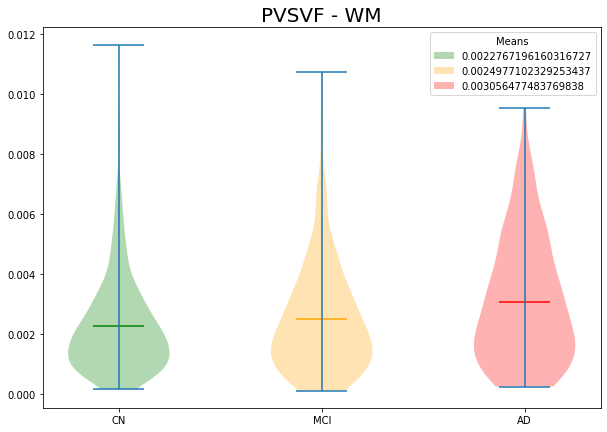

In [766]:
# step 6: plot stuff

#try: https://stackoverflow.com/questions/67376683/can-you-have-a-box-plot-overlap-a-half-violin-plot-on-a-raincloud-plot-using-pyt
#try: https://github.com/pog87/PtitPrince


## combine these different collections into a list
data_to_plot = [cn_txfm, mci_txfm, ad_txfm]

# Create a figure instance
fig = plt.figure(figsize=(10,7))

# Create the boxplot
violin = plt.violinplot(data_to_plot,positions=[1,2,3],showmeans=True,showextrema=True)

# Set the color of the violin patches
colors = ['Green', 'Orange', 'Red']
for pc, color in zip(violin['bodies'], colors):
    pc.set_facecolor(color)
violin['cmeans'].set_colors(colors)
plt.xticks([1, 2, 3], labels=['CN', 'MCI', 'AD'])
plt.legend([np.mean(cn_txfm), np.mean(mci_txfm), np.mean(ad_txfm)],title='Means')
#plt.ylim(cn_txfm.max()*-1.3,cn_txfm.max()*1.3)
plt.title('PVSVF - WM',fontsize=20)

# y, h, col = max(map(max, data_to_plot)) + 2, 2, 'k'
# plt.text(,y+h, "*", ha='center', va='bottom', color=col)

plt.show()

In [367]:
# stats comparison giant table
# need to compute: 
    # non transformed & transformed for: pvscount  pvsvol  icv norm  pvscountwm  pvsvolwm  icv norm wm
    # shapiro-wilks test for: pvscount  pvsvol  icv norm  pvscountwm  pvsvolwm  icv norm wm
    # ANOVA, ttest, kruskal wallis, mann whitney u for: cn vs ad, cn vs mci, mci vs ad for each condition above
    # means and std


    
    

In [368]:
# step n: regional stats (need to come up with a pipeline for this, not straight forward)
# should get: HP, GM / BG, CSO